# Hardware and Computational Capabilities

In [4]:
print()
print()

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Mon Dec 26 17:59:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing the libraries

In [5]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
from itertools import permutations 
import seaborn as sns
import imageio
from skimage.transform import rotate, AffineTransform, warp, resize
#import skvideo.io as vidio
#from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, SVG
import h5py
#from tabulate import tabulate

import torch
import torch.nn as nn
import torch.nn.functional as tF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
from torchvision import datasets, transforms, models
#from torchviz import make_dot
#from torchsummary import summary

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
#import matplotlib.animation as animation
%matplotlib inline

from sklearn.manifold import TSNE

#from torchvision.models.utils import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor
from collections import OrderedDict 

import pickle
import tarfile
import wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=0b3c8073e41f5e189c06864431b402c18b3809b6f0d53c652ea6c1f2f1df97ae
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


# Set the seed for reproducibility and create useful folders

In [6]:
def set_seed(seed = 16):
    np.random.seed(16)
    torch.manual_seed(16)

set_seed()

# create a folder called saved_models if it does not exist
if not os.path.exists('saved_models'):
    os.mkdir('saved_models')
    print('saved_models folder created')
else:
    print('saved_models folder already exists')

# create a folder called saved_plots if it does not exist
if not os.path.exists('saved_plots'):
    os.mkdir('saved_plots')
    print('saved_plots folder created')
else:
    print('saved_plots folder already exists')

saved_models folder created
saved_plots folder created


# Download SimCLR weights

To perform the downstream task we need weights from the training and implementation of SimCLR. 

You have two options:

1.   Perform your SimCLR training using Cifar100_SimCLR_Implementation.ipynb and save your training weights.
2.   Download the weights of the SimCLR training already done and peformated on 20 epochs.

For the option2, unfortunately google drive does not allow downloading large files using a python script without authentication. For this reason, you have to download the weights and manually upload them to colab.

Here you can find the pubblic link to download the file:
https://drive.google.com/file/d/12PSiedTd-qIMcNB8mY-uaHiQhNR1oXQn/view?usp=share_link

# Load SimCLR model and update weights

In [ ]:
from models.resnet_simclr import PreModel

# define the device to use and print it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(str(device) + " will be used.")

# define the model and move it to the device
model = PreModel('resnet50','avgpool').to(device)

# load the weights
weights = torch.load('SimCLR_CIFAR100_RN50_END_TRAINING_Epoch_n20pt')

# update model weights
model.load_state_dict(weights['model_state_dict'])

cuda:0 will be used.


<All keys matched successfully>

# Tuning SimCLR model for the downstream task
What we do is basically taking the SimCLR model already trained and we will use the output of the SimCLR model as the features of the images and then we will use the KNN layer to classify the images.

In the SimCLR model the projector is discarded in the downstream task model and the output of the encoder is used as the features of the images.

In [ ]:
class DSModel(nn.Module):
    def __init__(self,premodel,num_classes):
        super().__init__()
        
        self.premodel = premodel
        self.num_classes = num_classes
        
        for p in self.premodel.parameters():
            p.requires_grad = False
            
        for p in self.premodel.projector.parameters():
            p.requires_grad = False
        
    def forward(self,x):
        out = self.premodel.pretrained(x)
        return out

# define the downstream model
dsmodel = DSModel(model, 100).to('cuda:0')

# Load Cifar100 dataset and prepare it

In [ ]:
from download_cifar100 import load_cifar100

# load cifar-10 data
images, labels, testimages, testlabels = load_cifar100()

# reshape training images and test images to 32x32x3
images = images.reshape((-1,3,32,32))
images = images.reshape((-1,3,32,32))
# change training images and test images type to float32
images = images.astype(np.float)
testimages = testimages.astype(np.float)
print('Training images and test images reshaped to 32x32x3 and changed to float32')
print('Training images shape: ' + str(images.shape) + ' | Test images shape: ' + str(testimages.shape))

# change training labels and test labels type to int64
labels = labels.astype(np.int)
testlabels = testlabels.astype(np.int)
print('Training labels and test labels changed to int64')

#calculate the channel-wise mean and standard deviation of the pixel values on the training split
MEAN = np.mean(images[:40000]/255.0,axis=(0,2,3),keepdims=True)
STD = np.std(images[:40000]/255.0,axis=(0,2,3),keepdims=True)

#split 80:20 with batch5 as validation set
trimages = images[:40000]
valimages = images[40000:]
trlabels = labels[:40000]
vallabels = labels[40000:]

Train data loaded!
Train data shape: (50000, 3072) | Train labels shape: (50000,)
Test data loaded!
Test data shape: (10000, 3072) | Test labels shape: (10000,)


<ipython-input-18-175232608b4a>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  images = images.astype(np.float)
<ipython-input-18-175232608b4a>:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  testimages = testimages.astype(np.float)
<ipython-input-18-175232608b4a>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin

Training images and test images reshaped to 32x32x3 and changed to float32
Training images shape: (50000, 3, 32, 32) | Test images shape: (10000, 3072)
Training labels and test labels changed to int64


# Using pretrained SimCLR model for extracting features from the images
We will use the pretrained SimCLR model to extract the features from the images obtaining the output of the encoder in 2048 dimensions.

In [ ]:
# use PreModel to extract features from training images matching the shape of images in the downstream task
trfeatures = []
for i in range(trimages.shape[0]):
    img = torch.from_numpy(trimages[i]).float().unsqueeze(0).to('cuda:0')
    with torch.no_grad():
        out = dsmodel(img)
    trfeatures.append(out.cpu().numpy())

# use PreModel to extract features from validation images matching the shape of images in the downstream task
valfeatures = []
for i in range(valimages.shape[0]):
    img = torch.from_numpy(valimages[i]).float().unsqueeze(0).to('cuda:0')
    with torch.no_grad():
        out = dsmodel(img)
    valfeatures.append(out.cpu().numpy())

# we check the shape of the extracted features
print('Training features shape: ' + str(np.array(trfeatures).shape))
print('Validation features shape: ' + str(np.array(valfeatures).shape))

# we transform the features into a np arrays
trfeatures = np.array(trfeatures)
valfeatures = np.array(valfeatures)

# we reshape the extracted features data and placing into rows
X_train = np.reshape(trfeatures, (trfeatures.shape[0], -1))
X_test = np.reshape(valfeatures, (valfeatures.shape[0], -1))
print(X_train.shape, X_test.shape)

# we change the name of the variables
y_train = trlabels
y_test = vallabels

Training features shape: (40000, 1, 2048)
Validation features shape: (10000, 1, 2048)
(40000, 2048) (10000, 2048)


# KNN classification
We will use the KNN algorithm to classify the images rappresetend by the features extracted from the SimCLR model. We also try to train the KNN model with different number of neighbors and we will see how the accuracy of the model changes. We use a __k-fold cross validation__ to find the best value of k.

1. We try to classify with 5 neighbors
2. We perform a __k-fold cross validation__ to find the best value of k
3. We try to classify with best value of k
4. We evaluate the performance of the model

In [ ]:
from downstream.KNN import KNearestNeighbor

# Create a kNN classifier instance.
classifier = KNearestNeighbor()

# we define the number of training examples
num_test = 10000

# we train the classifier and compute distances
classifier.train(X_train, y_train)
dists= classifier.compute_distances(X_test)

# we compute the accuracy with k = 5
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test

# we print the accuracy
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 2178 / 10000 correct => accuracy: 0.217800


In [ ]:
# we calculate the recall and precision
from sklearn.metrics import recall_score, precision_score
recall = recall_score(y_test, y_test_pred, average='macro')
precision = precision_score(y_test, y_test_pred, average='macro')

# we print the recall and precision
print('Recall: ' + str(recall))
print('Precision: ' + str(precision))

# we calculate the f1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_test_pred, average='macro')

# we print the f1 score
print('F1 score: ' + str(f1))

# we calculate the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)

# we print the confusion matrix
print(cm)

# we calculate the classification report
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_test_pred)

# we print the classification report
print(cr)

Recall: 0.2155739629381435
Precision: 0.2732557499433851
F1 score: 0.21212561739211216
[[63  2  0 ...  0  0  0]
 [ 2 43  3 ...  1  1  0]
 [ 2  2 19 ...  1  0  1]
 ...
 [ 0  4  3 ... 20  0  0]
 [ 3  1 10 ...  1  9  1]
 [ 4  3  2 ...  0  0 18]]
              precision    recall  f1-score   support

           0       0.21      0.61      0.31       103
           1       0.12      0.38      0.19       113
           2       0.06      0.19      0.09        98
           3       0.07      0.20      0.11       102
           4       0.10      0.29      0.15       111
           5       0.20      0.40      0.26       109
           6       0.05      0.17      0.07        96
           7       0.10      0.26      0.15       109
           8       0.18      0.45      0.26        77
           9       0.32      0.45      0.37       102
          10       0.13      0.20      0.16       126
          11       0.10      0.19      0.13       102
          12       0.21      0.29      0.25       102


We perform a __k-fold cross validation__ to find the best value of k. For each possible value of k, we run the k-nearest-neighbor algorithm num_folds times, where in each case you use all but one of the folds as training data and the last fold as a validation set.


In [ ]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
k_to_accuracies = {}


for k in k_choices:
    k_to_accuracies[k] = []
    for num_knn in range(0,num_folds):
        X_test = X_train_folds[num_knn]
        y_test = y_train_folds[num_knn]
        X_train = X_train_folds
        y_train = y_train_folds
        
        temp = np.delete(X_train,num_knn,0)
        X_train = np.concatenate((temp),axis = 0)
        y_train = np.delete(y_train,num_knn,0)
        y_train = np.concatenate((y_train),axis = 0)
        
        classifier = KNearestNeighbor()
        classifier.train(X_train, y_train)
        dists = classifier.compute_distances(X_test)
        y_test_pred = classifier.predict_labels(dists, k)

        num_correct = np.sum(y_test_pred == y_test)
        accuracy = float(num_correct) / num_test
#         print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
        k_to_accuracies[k].append(accuracy)


print("Printing our 5-fold accuracies for varying values of k:")
print()

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

/content/drive/MyDrive/Data_Science/Secondo_Anno/Introduction_to_ML/ML Project/test_repo_Cifar100/downstream/KNN.py:22: RuntimeWarning: invalid value encountered in sqrt
  dists = np.sqrt(np.sum(np.square(self.X_train), axis=1) + np.sum(np.square(X), axis=1)[:, np.newaxis] - 2 * np.dot(X, self.X_train.T))


Printing our 5-fold accuracies for varying values of k:

k = 1, accuracy = 0.176800
k = 1, accuracy = 0.181300
k = 1, accuracy = 0.177300
k = 1, accuracy = 0.178000
k = 1, accuracy = 0.173900
k = 3, accuracy = 0.155500
k = 3, accuracy = 0.154300
k = 3, accuracy = 0.154300
k = 3, accuracy = 0.157200
k = 3, accuracy = 0.149900
k = 5, accuracy = 0.162800
k = 5, accuracy = 0.163900
k = 5, accuracy = 0.162000
k = 5, accuracy = 0.167200
k = 5, accuracy = 0.160000
k = 8, accuracy = 0.172600
k = 8, accuracy = 0.172100
k = 8, accuracy = 0.172200
k = 8, accuracy = 0.178300
k = 8, accuracy = 0.172500
k = 10, accuracy = 0.176400
k = 10, accuracy = 0.177300
k = 10, accuracy = 0.177400
k = 10, accuracy = 0.182200
k = 10, accuracy = 0.173700
k = 12, accuracy = 0.180000
k = 12, accuracy = 0.180200
k = 12, accuracy = 0.176500
k = 12, accuracy = 0.182100
k = 12, accuracy = 0.178700
k = 15, accuracy = 0.181200
k = 15, accuracy = 0.180200
k = 15, accuracy = 0.181000
k = 15, accuracy = 0.180800
k = 15, acc

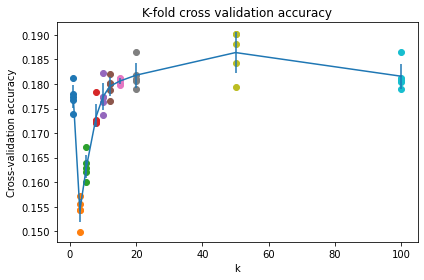

In [ ]:
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('K-fold cross validation accuracy')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.savefig('saved_plots/Cross-validation accuracy.png', transparent=True)
plt.tight_layout()
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k, we retrain the classifier using all the training data, and test it on the test
# data

best_k = k_choices[np.argmax(accuracies_mean)]

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test

print('Best k: %d' % best_k)
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Best k: 50
Got 1901 / 10000 correct => accuracy: 0.190100


Recall: 0.23771490898261532
Precision: 0.2467091892785315
F1 score: 0.2230578233992294

Confusion Matrix
[[60  3  1 ...  1  0  0]
 [ 0 33  1 ...  1  0  0]
 [ 0  3 10 ...  2  3  0]
 ...
 [ 0  2  1 ... 13  0  0]
 [ 1  1  6 ...  1  3  0]
 [ 0  0  1 ...  1  0  8]]

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.65      0.48        93
           1       0.14      0.53      0.22        62
           2       0.10      0.12      0.11        84
           3       0.09      0.11      0.10        73
           4       0.16      0.16      0.16        86
           5       0.41      0.33      0.36        82
           6       0.13      0.22      0.17        94
           7       0.05      0.10      0.07        70
           8       0.35      0.52      0.42        81
           9       0.67      0.45      0.54        89
          10       0.13      0.12      0.13        74
          11       0.18      0.15      0.17        80
          12 

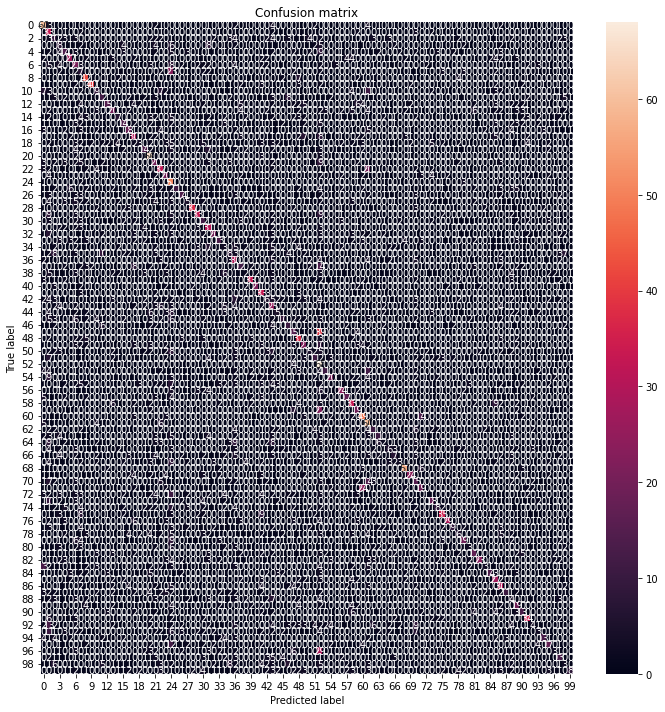

In [ ]:
# we calculate the recall and precision
from sklearn.metrics import recall_score, precision_score
recall = recall_score(y_test, y_test_pred, average='macro')
precision = precision_score(y_test, y_test_pred, average='macro')

# we print the recall and precision
print('Recall: ' + str(recall))
print('Precision: ' + str(precision))

# we calculate the f1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_test_pred, average='macro')

# we print the f1 score
print('F1 score: ' + str(f1))

# we calculate the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)

# we print the confusion matrix
print()
print('Confusion Matrix')
print(cm)

# we calculate the classification report
from sklearn.metrics import classification_report
cr = classification_report(y_test, y_test_pred)

# we print the classification report
print()
print('Classification Report')
print(cr)
print()

# we plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('saved_plots/SimCLR_KNN_confusion_matrix.png', transparent=True)
plt.tight_layout()
plt.show()

# save all the results
import pickle
with open('saved_models/SimCLR_KNN_classification_results.pkl', 'wb') as f:
    pickle.dump([accuracy, recall, precision, f1, cm, cr], f)

# We perform a T-SNE visualization of the features extracted from the images
We plot a T-SNE visualisation of the features learned by our model: we extract the representations of all images, reduce their dimensionality to 2 (with T-SNE) and show each point as a unique colour (related to its class).

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


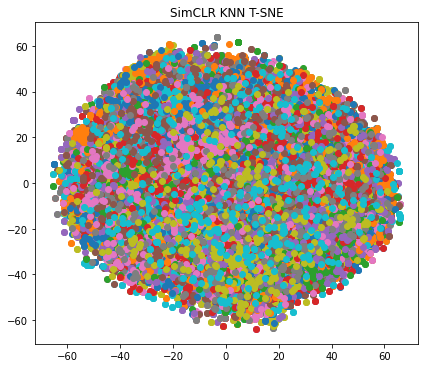

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

y = 100

# Perform t-SNE with 100 classes
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
X_tsne = tsne.fit_transform(X_train)

# Plot the t-SNE visualization
plt.figure(figsize=(6, 5))
for i in range(100):
    plt.scatter(X_2d[y_train == i, 0], X_2d[y_train == i, 1], label=i)
plt.tight_layout()
plt.title('SimCLR KNN T-SNE')
plt.savefig('saved_plots/SimCLR_KNN_T-SNE.png', transparent=True)
plt.show()